# Libraries

In [52]:
import pandas as pd
import os
import numpy as np

#data cleansing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

#logistic regression
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


#Export model
import pickle


###################################################################
# Personal library #
import sys
import os

# Path to the folder containing the pesonalized functions
folder_path = os.path.abspath(os.path.join('..', 'library'))
sys.path.insert(0, folder_path)

# Now you can import your module or functions
import la_functions as la

# Reading + Enriching the data

In [96]:
# Here I call the function data_enriching as defined in the module la_functions.py present in the folder library
df = la.data_enriching('data.csv')

# Here focus on 2023 only - to be changed as needed
df = df.query(" year_occurred==2023 ")

/home/elie/.pyenv/versions/3.10.6/envs/safe_live/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [97]:
len(df)

210051

In [98]:
for x in df :
    print(f"'{x}',")

'division_number',
'date_reported',
'date_occurred',
'area',
'area_name',
'reporting_district',
'part',
'crime_code',
'crime_description',
'modus_operandi',
'victim_age',
'victim_sex',
'victim_descent',
'premise_code',
'premise_description',
'weapon_code',
'weapon_description',
'status',
'status_description',
'crime_code_1',
'crime_code_2',
'crime_code_3',
'crime_code_4',
'location',
'cross_street',
'latitude',
'longitude',
'counter',
'year_occurred',
'month_occurred',
'day_occurred',
'hour_occurred',
'geometry',
'index_right',
'OBJECTID',
'name',
'gravity_for_tourist',


# Getting the data

In [100]:
print(df.columns)

Index(['division_number', 'date_reported', 'date_occurred', 'area',
       'area_name', 'reporting_district', 'part', 'crime_code',
       'crime_description', 'modus_operandi', 'victim_age', 'victim_sex',
       'victim_descent', 'premise_code', 'premise_description', 'weapon_code',
       'weapon_description', 'status', 'status_description', 'crime_code_1',
       'crime_code_2', 'crime_code_3', 'crime_code_4', 'location',
       'cross_street', 'latitude', 'longitude', 'counter', 'year_occurred',
       'month_occurred', 'day_occurred', 'hour_occurred', 'geometry',
       'index_right', 'OBJECTID', 'name', 'gravity_for_tourist'],
      dtype='object')


In [6]:
columns_keep = [
#'division_number',
#'date_reported',
'date_occurred',
#'area',
#'area_name',
#'reporting_district',
#'part',
#'crime_code',
'crime_description',
#'modus_operandi',
'victim_age',
'victim_sex',
'victim_descent',
#'premise_code',
#'premise_description',
#'weapon_code',
#'weapon_description',
#'status',
#'status_description',
#'crime_code_1',
#'crime_code_2',
#'crime_code_3',
#'crime_code_4',
#'location',
#'cross_street',
#'latitude',
#'longitude',

'year_occurred',
'month_occurred',
'day_occurred',
'hour_occurred',
'geometry',#not for model
'index_right',#not for model
'OBJECTID',#not for model
'name',#name area
'gravity_for_tourist'# target
]

In [7]:
df = df[columns_keep]
df.head(3)

date_occurred  crime_description  victim_age victim_sex  \
112274 2023-04-29 16:00:00   VEHICLE - STOLEN           0        NaN   
225174 2023-07-03 14:00:00  THEFT OF IDENTITY          33          M   
409220 2023-10-19 19:40:00   VEHICLE - STOLEN           0        NaN   

       victim_descent  year_occurred  month_occurred  hour_occurred  \
112274            NaN           2023               4             16   
225174              W           2023               7             14   
409220            NaN           2023              10             19   

        day_occurred  hour_occurred                     geometry  index_right  \
112274            29             16  POINT (-118.29410 34.06720)         52.0   
225174             3             14  POINT (-118.43240 34.03300)         77.0   
409220            19             19  POINT (-118.44030 34.21660)         71.0   

        OBJECTID           name  gravity_for_tourist  
112274      53.0      Koreatown                    1  
225174      78.0    Rancho Park                    1  
409220      72.0  Panorama City                    1

# Data Cleansing

## 1. Basic Cleansing

In [8]:
#Removing illogical values and replacing erronous values

#removing negative age values
df=df[df['victim_age']>=0]

#removing null gender values
df = df[df['victim_sex'].notnull()]
df = df[df['victim_descent'].notnull()]


In [9]:
#exploring unique values for victim descent and victim sex columns
df['victim_sex'].unique(), df['victim_descent'].unique()

(array(['M', 'X', 'F', 'H', '-'], dtype=object),
 array(['W', 'X', 'H', 'O', 'B', 'F', 'A', 'K', 'C', 'J', 'Z', 'I', 'D',
        'V', 'G', 'P', 'S', 'L', 'U', '-'], dtype=object))

In [10]:
# from the above cell , '-' is present in both columns so we need to remove rows that contain it (they're not that many)
df=df[df['victim_sex'] != '-']
df=df[df['victim_descent'] != '-']

In [11]:
#checking the above code worked
df['victim_sex'].unique(), df['victim_descent'].unique()

(array(['M', 'X', 'F', 'H'], dtype=object),
 array(['W', 'X', 'H', 'O', 'B', 'F', 'A', 'K', 'C', 'J', 'Z', 'I', 'D',
        'V', 'G', 'P', 'S', 'L', 'U'], dtype=object))

In [12]:
len(df)

181259

# This one is included in the data_enriching function
# Parse datetime string to datetime object

df['date_occurred'] = pd.to_datetime(df['date_occurred'], errors='coerce')

#create new date and time columns
df['year_occurred'] = df['date_occurred'].dt.year
df['month_occurred'] = df['date_occurred'].dt.month
df['hour_occurred'] = df['date_occurred'].dt.hour
df['day_occurred'] = df['date_occurred'].dt.day

df.head(3)

In [13]:
# Create new column 'time_of_day' based on time
def categorize_time(hour):
    if 6 <= hour < 12:
        return 1#'morning'
    elif 12 <= hour < 18:
        return 2#'afternoon'
    elif 18 <= hour < 24:
        return 3#'evening'
    else:
        return 4#'night'

df['time_of_day'] = df['hour_occurred'].apply(categorize_time)

## 1.2 one hot encoding victim_sex and victim_descent

In [14]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [15]:
df = pd.get_dummies(df, columns=['victim_descent', 'victim_sex'])
df = df.replace({True: 1, False: 0})

df.head()

/tmp/ipykernel_57947/3463276855.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({True: 1, False: 0})


date_occurred                         crime_description  \
225174 2023-07-03 14:00:00                         THEFT OF IDENTITY   
409723 2023-06-17 11:40:00  SHOPLIFTING - PETTY THEFT ($950 & UNDER)   
409779 2023-02-11 16:30:00        THEFT PLAIN - PETTY ($950 & UNDER)   
409947 2023-01-23 12:00:00                                  BURGLARY   
411222 2023-05-16 15:50:00  SHOPLIFTING - PETTY THEFT ($950 & UNDER)   

        victim_age  year_occurred  month_occurred  hour_occurred  \
225174          33           2023               7             14   
409723           0           2023               6             11   
409779          48           2023               2             16   
409947          60           2023               1             12   
411222          22           2023               5             15   

        day_occurred  hour_occurred                     geometry  index_right  \
225174             3             14  POINT (-118.43240 34.03300)         77.0   
409723            17             11  POINT (-118.30920 34.09810)         25.0   
409779            11             16  POINT (-118.27260 34.03960)         23.0   
409947            23             12  POINT (-118.59510 34.21380)         12.0   
411222            16             15  POINT (-118.27120 34.05390)        106.0   

        OBJECTID            name  gravity_for_tourist time_of_day  \
225174      78.0     Rancho Park                    1   afternoon   
409723      26.0  East Hollywood                    1     morning   
409779      24.0        Downtown                    1   afternoon   
409947      13.0     Canoga Park                    2   afternoon   
411222     107.0        Westlake                    1   afternoon   

        victim_descent_A  victim_descent_B  victim_descent_C  \
225174                 0                 0                 0   
409723                 0                 0                 0   
409779                 0                 0                 0   
409947                 0                 0                 0   
411222                 0                 0                 0   

        victim_descent_D  victim_descent_F  victim_descent_G  \
225174                 0                 0                 0   
409723                 0                 0                 0   
409779                 0                 0                 0   
409947                 0                 0                 0   
411222                 0                 0                 0   

        victim_descent_H  victim_descent_I  victim_descent_J  \
225174                 0                 0                 0   
409723                 0                 0                 0   
409779                 1                 0                 0   
409947                 1                 0                 0   
411222                 1                 0                 0   

        victim_descent_K  victim_descent_L  victim_descent_O  \
225174                 0                 0                 0   
409723                 0                 0                 0   
409779                 0                 0                 0   
409947                 0                 0                 0   
411222                 0                 0                 0   

        victim_descent_P  victim_descent_S  victim_descent_U  \
225174                 0                 0                 0   
409723                 0                 0                 0   
409779                 0                 0                 0   
409947                 0                 0                 0   
411222                 0                 0                 0   

        victim_descent_V  victim_descent_W  victim_descent_X  \
225174                 0                 1                 0   
409723                 0                 0                 1   
409779                 0                 0                 0   
409947                 0                 0                 0   
411222                 0

# SVM Classification Model

## cross validate

In [16]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 181259 entries, 225174 to 852949
Data columns (total 38 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date_occurred        181259 non-null  datetime64[ns]
 1   crime_description    181259 non-null  object        
 2   victim_age           181259 non-null  int64         
 3   latitude             181259 non-null  float64       
 4   longitude            181259 non-null  float64       
 5   year_occurred        181259 non-null  int32         
 6   month_occurred       181259 non-null  int32         
 7   day_occurred         181259 non-null  int32         
 8   hour_occurred        181259 non-null  int32         
 9   geometry             181259 non-null  geometry      
 10  index_right          179493 non-null  float64       
 11  OBJECTID             179493 non-null  float64       
 12  name                 179493 non-null  object        
 13  gravit

In [17]:

# Convert date features into cyclical features

# Year
df['year_sin'] = np.sin(2 * np.pi * df['year_occurred'] / max(df['year_occurred']))
df['year_cos'] = np.cos(2 * np.pi * df['year_occurred'] / max(df['year_occurred']))

# Month
df['month_sin'] = np.sin(2 * np.pi * df['month_occurred'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_occurred'] / 12)

# Day
df['day_sin'] = np.sin(2 * np.pi * df['day_occurred'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day_occurred'] / 31)

# Hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour_occurred'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour_occurred'] / 24)


In [31]:
# create the feature set
X = df.drop(['date_occurred', 'crime_description', 'geometry', 'index_right', 'OBJECTID', 'name', 'gravity_for_tourist', 'time_of_day','year_occurred','month_occurred','day_occurred','hour_occurred'], axis=1)
y=df['gravity_for_tourist']

In [32]:
X.head()

victim_age  latitude  longitude  victim_descent_A  victim_descent_B  \
225174          33   34.0330  -118.4324                 0                 0   
409723           0   34.0981  -118.3092                 0                 0   
409779          48   34.0396  -118.2726                 0                 0   
409947          60   34.2138  -118.5951                 0                 0   
411222          22   34.0539  -118.2712                 0                 0   

        victim_descent_C  victim_descent_D  victim_descent_F  \
225174                 0                 0                 0   
409723                 0                 0                 0   
409779                 0                 0                 0   
409947                 0                 0                 0   
411222                 0                 0                 0   

        victim_descent_G  victim_descent_H  victim_descent_I  \
225174                 0                 0                 0   
409723                 0                 0                 0   
409779                 0                 1                 0   
409947                 0                 1                 0   
411222                 0                 1                 0   

        victim_descent_J  victim_descent_K  victim_descent_L  \
225174                 0                 0                 0   
409723                 0                 0                 0   
409779                 0                 0                 0   
409947                 0                 0                 0   
411222                 0                 0                 0   

        victim_descent_O  victim_descent_P  victim_descent_S  \
225174                 0                 0                 0   
409723                 0                 0                 0   
409779                 0                 0                 0   
409947                 0                 0                 0   
411222                 0                 0                 0   

        victim_descent_U  victim_descent_V  victim_descent_W  \
225174                 0                 0                 1   
409723                 0                 0                 0   
409779                 0                 0                 0   
409947                 0                 0                 0   
411222                 0                 0                 0   

        victim_descent_X  victim_descent_Z  victim_sex_F  victim_sex_H  \
225174                 0                 0             0             0   
409723                 1                 0             0             0   
409779                 0                 0             0             0   
409947                 0                 0             1             0   
411222                 0                 0             0             0   

        victim_sex_M  victim_sex_X      year_sin  year_cos     month_sin  \
225174             1             0 -2.449294e-16       1.0 -5.000000e-01   
409723             0             1 -2.449294e-16       1.0  1.224647e-16   
409779             1             0 -2.449294e-16       1.0  8.660254e-01   
409947             0             0 -2.449294e-16       1.0  5.000000e-01   
411222             1             0 -2.449294e-16       1.0  5.000000e-01   

        month_cos   day_sin   day_cos      hour_sin  hour_cos  
225174  -0.866025  0.571268  0.820763 -5.000000e-01 -0.866025  
409723  -1.000000 -0.299363 -0.954139  2.588190e-01 -0.965926  
409779   0.500000  0.790776 -0.612106 -8.660254e-01 -0.500000  
409947   0.866025 -0.998717 -0.050649  1.224647e-16 -1.000000  
411222  -0.866025 -0.101168 -0.994869 -7.071068e-01 -0.707107

In [33]:
# normalize some columns
scaler=MinMaxScaler()
X[['victim_age','latitude','longitude']]=scaler.fit_transform(X[['victim_age','latitude','longitude']])

In [43]:
max_samples=10000

random_indices = X.sample(n=max_samples, random_state=42).index

# Use the sampled indices to get both X_subset and y_subset
X_subset = X.loc[random_indices]
y_subset = y.loc[random_indices]

In [45]:
X_subset.shape, y_subset.shape

((10051, 34), (10051,))

In [46]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)

In [47]:
svm_model=SVC(kernel='linear')

In [49]:
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [50]:
# Make predictions on the testing data
y_pred = svm_model.predict(X_test)

In [53]:
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7140726006961711


# Logistic regression

In [110]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 181259 entries, 225174 to 852949
Data columns (total 35 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date_occurred        181259 non-null  datetime64[ns]
 1   crime_description    181259 non-null  object        
 2   victim_age           181259 non-null  int64         
 3   year_occurred        181259 non-null  int32         
 4   month_occurred       181259 non-null  int32         
 5   hour_occurred        181259 non-null  int32         
 6   geometry             181259 non-null  geometry      
 7   index_right          179493 non-null  float64       
 8   OBJECTID             179493 non-null  float64       
 9   name                 179493 non-null  object        
 10  gravity_for_tourist  181259 non-null  int64         
 11  time_of_day          181259 non-null  int64         
 12  victim_descent_A     181259 non-null  int64         
 13  victim

In [113]:
df=df[df['victim_age']>0]

columns_keep = [
'date_occurred',
'crime_description',
'victim_age',
'victim_sex',
'victim_descent',
'year_occurred',
'month_occurred',
'hour_occurred',
'geometry',#not for model
'index_right',#not for model
'OBJECTID',#not for model
'name',#name area
'gravity_for_tourist'# target
]

In [114]:
#Create the feature set
features = [
    'victim_age',
    'month_occurred',
    'time_of_day',
    'victim_descent_A',
    'victim_descent_B',
    'victim_descent_C',
    'victim_descent_D',
    'victim_descent_F',
    'victim_descent_G',
    'victim_descent_H',
    'victim_descent_I',
    'victim_descent_J',
    'victim_descent_K',
    'victim_descent_L',
    'victim_descent_O',
    'victim_descent_P',
    'victim_descent_S',
    'victim_descent_U',
    'victim_descent_V',
    'victim_descent_W',
    'victim_descent_X',
    'victim_descent_Z',
    'victim_sex_F',
    'victim_sex_H',
    'victim_sex_M',
    'victim_sex_X'
    ]
X = df[features]
y = df['gravity_for_tourist']

In [115]:
X.head()

victim_age  month_occurred  time_of_day  victim_descent_A  \
225174          33               7            2                 0   
409779          48               2            2                 0   
409947          60               1            2                 0   
411222          22               5            2                 0   
411278           3               4            3                 0   

        victim_descent_B  victim_descent_C  victim_descent_D  \
225174                 0                 0                 0   
409779                 0                 0                 0   
409947                 0                 0                 0   
411222                 0                 0                 0   
411278                 0                 0                 0   

        victim_descent_F  victim_descent_G  victim_descent_H  \
225174                 0                 0                 0   
409779                 0                 0                 1   
409947                 0                 0                 1   
411222                 0                 0                 1   
411278                 0                 0                 0   

        victim_descent_I  victim_descent_J  victim_descent_K  \
225174                 0                 0                 0   
409779                 0                 0                 0   
409947                 0                 0                 0   
411222                 0                 0                 0   
411278                 0                 0                 0   

        victim_descent_L  victim_descent_O  victim_descent_P  \
225174                 0                 0                 0   
409779                 0                 0                 0   
409947                 0                 0                 0   
411222                 0                 0                 0   
411278                 0                 1                 0   

        victim_descent_S  victim_descent_U  victim_descent_V  \
225174                 0                 0                 0   
409779                 0                 0                 0   
409947                 0                 0                 0   
411222                 0                 0                 0   
411278                 0                 0                 0   

        victim_descent_W  victim_descent_X  victim_descent_Z  victim_sex_F  \
225174                 1                 0                 0             0   
409779                 0                 0                 0             0   
409947                 0                 0                 0             1   
411222                 0                 0                 0             0   
411278                 0                 0                 0             0   

        victim_sex_H  victim_sex_M  victim_sex_X  
225174             0             1             0  
409779             0             1             0  
409947             0             0             0  
411222             0             1             0  
411278             0             1             0

In [116]:
y.head()

225174    1
409779    1
409947    2
411222    1
411278    2
Name: gravity_for_tourist, dtype: int64

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
# Checking whether a numerical feature has a normal distribution or not
#from statsmodels.graphics.gofplots import qqplot

<Axes: title={'center': 'Boxplot of the victim_age'}, xlabel='victim_age'>

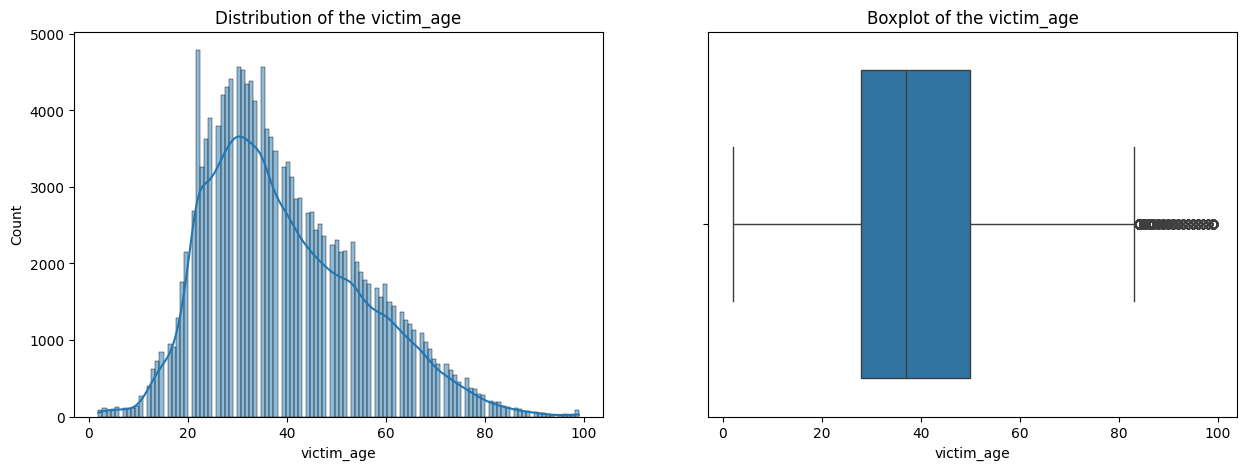

In [118]:
# It is crucial to to understand the overall distribution, the potential outliers...
# and also the Gaussianity with QQplot... before Scaling!

variable = 'victim_age'

fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].set_title(f"Distribution of the {variable}")
sns.histplot(data = df, x = f"{variable}", kde=True, ax = ax[0])

ax[1].set_title(f"Boxplot of the {variable}")
sns.boxplot(data = df, x = f"{variable}", ax=ax[1])


## Scaling

In [119]:
#from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


#scaler = RobustScaler()
#scaler = StandardScaler()
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

df_scaled = pd.DataFrame(X_scaled, columns=features)

In [ ]:
df_scaled.head()

<Axes: title={'center': 'Boxplot of the victim_age'}, xlabel='victim_age'>

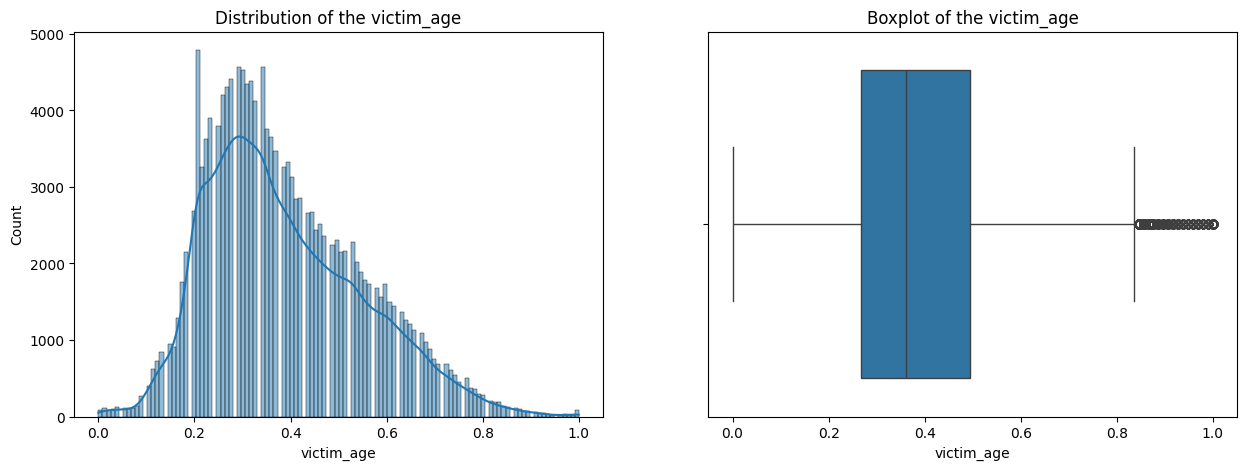

In [120]:
variable = 'victim_age'

fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].set_title(f"Distribution of the {variable}")
sns.histplot(data = df_scaled, x = f"{variable}", kde=True, ax = ax[0])

ax[1].set_title(f"Boxplot of the {variable}")
sns.boxplot(data = df_scaled, x = f"{variable}", ax=ax[1])

## Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV

In [ ]:
model = RandomForestRegressor(max_depth=50,min_samples_leaf=20)

score = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error' )

print(score.std())
print(score.mean())

In [ ]:
#train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=0)

In [ ]:
#Fit the model
model.fit(X_train, y_train)

In [ ]:
# Predict
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:


# MSE
mse = mean_squared_error(y_test, y_pred)
print(mse)

# MAE
mae = mean_absolute_error(y_test, y_pred)
print(mae)

# R-squared
r2 = r2_score(y_test, y_pred)
print(r2)

In [ ]:
#Optimization

param_grid = {
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_leaf': [10, 20, 30, 40, 50]
}

model = RandomForestRegressor(max_depth=50, min_samples_leaf=20)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)


print("Best hyperparameters :", grid_search.best_params_)


best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

In [ ]:
# MSE
mse = mean_squared_error(y_test, predictions)
print(mse)

# MAE
mae = mean_absolute_error(y_test, predictions)
print(mae)

# R-squared
r2 = r2_score(y_test, predictions)
print(r2)

## Random forest with Scalling

In [121]:
model = RandomForestRegressor(max_depth=50,min_samples_leaf=20)

In [122]:
#train and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    test_size=0.3,
                                                    random_state=0)

In [123]:
#Fit the model
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=50, min_samples_leaf=20)

In [ ]:
# Predict
y_pred = model.predict(X_test)

In [124]:
# MSE
mse = mean_squared_error(y_test, y_pred)
print(mse)

# MAE
mae = mean_absolute_error(y_test, y_pred)
print(mae)

# R-squared
r2 = r2_score(y_test, y_pred)
print(r2)

0.23696460283625195
0.4163861006549896
0.015586764336565584


In [ ]:
#Optimization

param_grid = {
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_leaf': [10, 20, 30, 40, 50]
}

model = RandomForestRegressor(max_depth=50, min_samples_leaf=20)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)


print("Best hyperparameters :", grid_search.best_params_)


best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

In [ ]:
# MSE
mse = mean_squared_error(y_test, predictions)
print(mse)

# MAE
mae = mean_absolute_error(y_test, predictions)
print(mae)

# R-squared
r2 = r2_score(y_test, predictions)
print(r2)

## Learning curves 

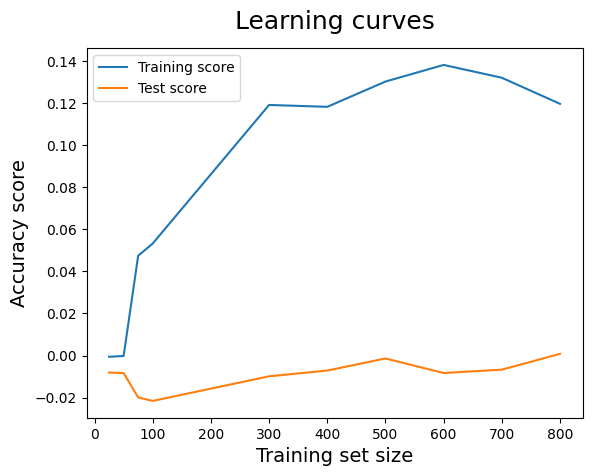

In [125]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = RandomForestRegressor(max_depth=50, min_samples_leaf=20),
                                                              X = X_scaled,
                                                              y = y,
                                                              train_sizes = [25,50,75,100,300,400,500,600,700,800],
                                                              cv = 20)

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot the learning curves!
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('Accuracy score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
#plt.xlim([0, 1000])
#plt.ylim([0, 1])
plt.legend()

# Export model

In [ ]:
# Export model as pickle file
with open("ml_model.pkl", "wb") as file:
    pickle.dump(log_model, file)

# Load Pipeline from pickle file
my_model = pickle.load(open("ml_model.pkl","rb"))

my_model.score(X_test, y_test)

# Import model

In [ ]:
# Load pipeline from pickle file
my_model = pickle.load(open("ml_model.pkl", "rb"))

my_model

## SVM

In [ ]:
from sklearn.svm import SVR

In [ ]:
# Create eval test just for early-stopping purposes (XGBOOST and Deep Learning)
X_train, X_eval, y_train, y_eval = train_test_split(X_scaled, y, random_state=42)

In [ ]:
model = SVR(kernel='rbf', C = 10)


cross_val_score(pipe_svm_rbf, X, y, cv=5, scoring=rmse).mean()

In [ ]:
param_grid =  {
        'svr__C': [0.5, 0.7, 1, 2, 5, 10],
        'svr__epsilon': [0.01, 0.05, 0.1, 0.2, 0.5],
        #'svr__coef0': [0.0, 0.1, 0.5,1],
    }

    search_svm_rbf = GridSearchCV(
        pipe_svm_rbf,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        verbose=2,
        scoring=rmse_neg
    )

    search_svm_rbf.fit(X, y_log);

    svm_rbf_best = search_svm_rbf.best_estimator_

    print('\n----------------------------------------\n')
    print(f'Best params ðŸ‘‰ {search_svm_rbf.best_params_}')
    print(f'Best score ðŸ‘‰ {search_svm_rbf.best_score_}')